## GradCAM CLIP

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

In [4]:
import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn

In [127]:
def normalize(x: np.ndarray) -> np.ndarray:        # 표준화 
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

In [128]:
def getAttMap(img, attn_map, blur=True):                  #attentionmap구하기
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):                      #visualize
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

In [129]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()
        
    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)
        
    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:        
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()
    
        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)
    
    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
        
    return gradcam

In [166]:
from torchvision import transforms

# 1번

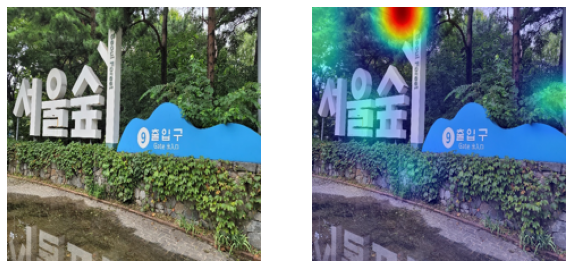

In [138]:
image_caption = 'the forest' # text token 정하기 
#@markdown #### CLIP model settings
clip_model = "RN50" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
#@markdown #### Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)   # 모델 및 모델의 전처리 방법 불러오기 


image_input = preprocess(Image.open('C:/Users/82102/Desktop/dataset/train/001.png')).unsqueeze(0).to(device)  # 이미지 전처리 
image = Image.open('C:/Users/82102/Desktop/dataset/train/001.png').convert("RGB")
resize = model.visual.input_resolution
if resize is not None:
    image = image.resize((resize, resize))
    image_np = np.asarray(image).astype(np.float32) / 255.
text_input = clip.tokenize([image_caption]).to(device) # text token 만들기 

attn_map = gradCAM(                       # gradcam 시행 
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

# 3번

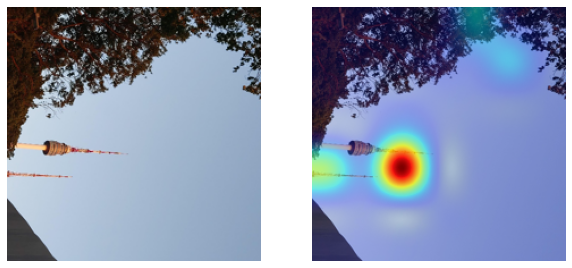

In [165]:
 image_caption = 'the building' 
#@markdown #### CLIP model settings
clip_model = "RN50" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
#@markdown #### Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)


image_input = preprocess(Image.open('C:/Users/82102/Desktop/dataset/train/003.png')).unsqueeze(0).to(device)
image = Image.open('C:/Users/82102/Desktop/dataset/train/003.png').convert("RGB")
resize = model.visual.input_resolution
if resize is not None:
    image = image.resize((resize, resize))
    image_np = np.asarray(image).astype(np.float32) / 255.
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


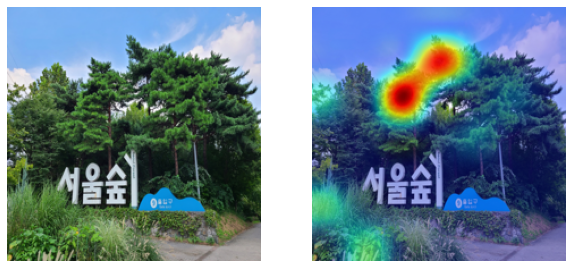

In [61]:
image_caption = 'the forest ' #@param {type:"string"}
#@markdown ---
#@markdown #### CLIP model settings
clip_model = "RN50" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
#@markdown ---
#@markdown #### Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)


image_input = preprocess(Image.open('C:/Users/82102/Desktop/dataset/train/004.png')).unsqueeze(0).to(device)
image = Image.open('C:/Users/82102/Desktop/dataset/train/004.png').convert("RGB")
text_input = clip.tokenize([image_caption]).to(device)
resize = model.visual.input_resolution
if resize is not None:
    image = image.resize((resize, resize))
    image_np = np.asarray(image).astype(np.float32) / 255.
text_input = clip.tokenize([image_caption]).to(device)
attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


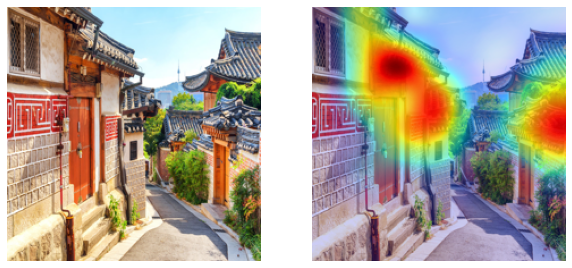

In [62]:
image_url = 'https://a.cdn-hotels.com/gdcs/production132/d234/6dccbffd-89a1-487b-9bd1-bae6f1ad0529.jpg' #@param {type:"string"}

image_caption = 'the traditional Korean village ' #@param {type:"string"}
#@markdown ---
#@markdown #### CLIP model settings
clip_model = "RN50" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
#@markdown ---
#@markdown #### Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

# Download the image from the web.
image_path = 'image.png'
urllib.request.urlretrieve(image_url, image_path)

image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

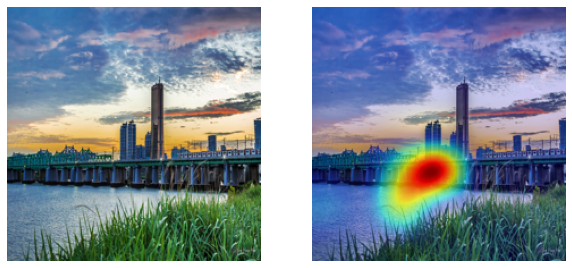

In [168]:
image_url = 'https://th.bing.com/th/id/R.a190915a9a64110306332be6f883022f?rik=BvgLyDWvEYQ9og&riu=http%3a%2f%2fwww.popco.net%2fzboard%2fdata%2fphoto_gallery%2f2015%2f07%2f18%2f5178675255a9d8790c15b.jpg&ehk=AFuZe2%2f8W2D9%2buWgFdXE0e8PJ83ghHGKvEBUnplg4v4%3d&risl=&pid=ImgRaw&r=0.jpg' #@param {type:"string"}

image_caption = 'the river ' #@param {type:"string"}
#@markdown ---
#@markdown #### CLIP model settings
clip_model = "RN50" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
#@markdown ---
#@markdown #### Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

# Download the image from the web.
image_path = 'image.png'
urllib.request.urlretrieve(image_url, image_path)

image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)